# Тема: Цикл анализа данных и моделирования
# Проект: Предсказание оттока клиентов    

**Описание проекта**  
Оператор связи «ТелеДом» хочет бороться с оттоком клиентов. Для этого его сотрудники начнут предлагать промокоды и специальные условия всем, кто планирует отказаться от услуг связи. Чтобы заранее находить таких пользователей, «ТелеДому» нужна модель, которая будет предсказывать, разорвёт ли абонент договор. Команда оператора собрала персональные данные о некоторых клиентах, информацию об их тарифах и услугах. Ваша задача — обучить на этих данных модель для прогноза оттока клиентов.

# План выполнения проекта

После каждого пункта следуют выводы и в заключение подводится общий итог

План работы

- 1 Загрузка данных
  - Загрузка данных и первичный осмотр
- 2 Исследовательский анализ и предобработка данных
  - Исследовательский анализ каждого датафрейма и предобработка, анализ релевантности признаков
  - Объединение выбранных признаков в один датафрейм
  - Исследовательский анализ объединённого датафрейма, визуализация распределений признаков и предобработка
  - Проведение корреляционного анализа
  - Подготовка данных для обучения модели, разделение данные на две выборки
- 3 Обучение моделей машинного обучения
  - Обучение нескольких моделей, подбор гиперпараметров
- 4 Выбор лучшей модели
  - Выбор лучшей модели и проверка её качества на тестовой выборке
- 5 Общий вывод и рекомендации заказчику
  - Общий вывод о проделанной работе: описание основных этапов работы и полученных результатов, выработка рекомендаций для бизнеса

In [1]:
import pandas as pd
import numpy as np
import phik
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import chi2_contingency
import time
import shap
from datetime import datetime, date, timedelta

from sklearn.preprocessing import OrdinalEncoder, StandardScaler
from sklearn.compose import make_column_transformer
from sklearn.metrics import recall_score, precision_score, roc_auc_score, f1_score
from sklearn.metrics import precision_recall_curve, roc_curve, ConfusionMatrixDisplay, confusion_matrix
from sklearn.metrics import classification_report, auc
from sklearn.calibration import CalibratedClassifierCV
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.pipeline import Pipeline

from sklearn.dummy import DummyClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression, RidgeClassifier, SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier, HistGradientBoostingClassifier
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier

from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier, Pool

RANDOM_STATE = 160224
sns.set_theme()

In [2]:
def load_df(file_name, sep =',', path='Yandex®'):
    try:
        data = pd.read_csv(file_name, sep=sep)
    except:
        data = pd.read_csv(path + file_name)
    return data

In [3]:
def display_statistics(data, freq_values=True):
    if freq_values:
        freq_name = 'freq_values'
        freq_num = 3
    else:
        freq_name = 'most_freq'
        freq_num = 1
    return pd.DataFrame(
        {'type': [data[x].dtypes for x in data.columns],
         'count' : [data[x].count() for x in data.columns],
         'NaNs' : [data[x].isna().sum() for x in data.columns],
         'zero_values': [data[x].eq(0).sum() for x in data.columns],
         'unique_values': [data[x].nunique() for x in data.columns],
         freq_name: [data[x].value_counts().head(freq_num).to_dict() for x in data.columns],
         'min': [data[x].min() if data[x].dtype!=object else '---' for x in data.columns],
         'mean': [data[x].mean() if data[x].dtype!=object else '---' for x in data.columns],
         'max': [data[x].max() if data[x].dtype!=object else '---' for x in data.columns],
         'std': [data[x].std() if data[x].dtype!=object else '---' for x in data.columns],
         'lo_count': [lo_hi_count(data, x) for x in data.columns],
         'hi_count': [lo_hi_count(data, x, 'H') for x in data.columns],
        }, index = [x for x in data.columns])


def lo_hi_count(data, col, what='L'):
    if data[col].dtype != float and data[col].dtype != int and data[col].dtype != 'datetime64[ns]':
        return '---'
    Q1 = np.nanquantile(data[col], 0.25)
    Q3 = np.nanquantile(data[col], 0.75)
    QL = Q1 - 1.5 * (Q3 - Q1)
    QH =  Q3 + 1.5 * (Q3 - Q1)
    if what=='L':
        return data[data[col] <= QL][col].count()
    else:
        return data[data[col] >= QH][col].count()

    
def tabulated_output(headers, data, first_col_as_index=True, title=None):
    if first_col_as_index:
        index = [x[0] for x in data]
        data = [x[1:] for x in data]
        index_name = headers[0]
        pdf = pd.DataFrame(data, columns = headers[1:], index=index)
        pdf.index.name= index_name 
    else:
        pdf = pd.DataFrame(data, columns = headers)
    if title:
        pdf.columns = pd.MultiIndex.from_product([[title], pdf.columns])
    return pdf


def print_classification_report(y_test, y_pred):
    cr = classification_report(y_test, y_pred, output_dict=True)
    res = []
    for x, y in cr.items():
        if x!='accuracy':
            res.append([x]+[z for z in y.values()])
        else:
            res.append(['accuracy', '', '', '', y])
    display(tabulated_output(['', 'precision ', 'recall', 'f1-score', 'support'], res))


def pr_rec_curve(model, X_valid, y_valid):
    proba_valid = model.predict_proba(X_valid)
    precision, recall, thresholds = precision_recall_curve(y_valid, proba_valid[:, 1])
    plt.figure(figsize=(8, 8))
    plt.step(recall, precision, where='post')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.title('Кривая Precision-Recall')
    plt.show() 


def plot_roc_auc(model, X_valid, y_valid):
    probabilities_valid = model.predict_proba(X_valid)
    probabilities_one_valid = probabilities_valid[:, 1]
    fpr, tpr, thresholds = roc_curve(y_valid, probabilities_one_valid)
    plt.figure(figsize=(8,8))
    plt.plot(fpr,tpr)
    plt.text(0.5, 0.1, f'Площадь под ROC-кривой = {roc_auc_score(y_valid, probabilities_one_valid)}')
    plt.plot([0, 1], [0, 1], linestyle='--')
    plt.xlim(-0.01,1.01)
    plt.ylim(-0.01,1.01)
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC-кривая")
    plt.show()

## Загрузка данных

In [4]:
path = '/datasets/'

datasets = {}
datasets['contract'] = load_df(path + 'contract_new.csv')
datasets['personal'] = load_df(path + 'personal_new.csv')
datasets['internet'] = load_df(path + 'internet_new.csv')
datasets['phone'] = load_df(path + 'phone_new.csv')

for (name, df) in datasets.items():
    print('='*50, name, '='*50)
    df.info()
    display(df.head(3))

================================================== contract ==================================================
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB


,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,31.04
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,2071.84
2,3668-QPYBK,2019-10-01,No,Month-to-month,Yes,Mailed check,53.85,226.17


================================================== personal ==================================================
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No


================================================== internet ==================================================
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB


,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No


================================================== phone ==================================================
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB


,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No


Загруженные датасеты:  
contract - сведения о договорах с клиентами, ключ customer_id, данные разных типов, пропусков нет  
personal - сведения о клиентах, ключ customer_id, данные категориальные, пропусков нет  
internet - сведения об интернет-услугах, оказываемым клиентам, ключ customer_id, пропусков нет  
phone - сведения об услугах телефонии, одно категориальное поле, ключ customer_id, пропусков нет

**Вывод по шагу 1**
- данные загружены успешно, присутствует общий ключ, данные разных типов, пропусков нет

## Исследовательский анализ и предобработка данных

Приведем названия столбцов к каноническому стилю и объединим датасеты в один по индексу.

In [5]:
def to_snake_style(x):
    x = x[0].lower() + x[1:-1] + x[-1].lower()
    return "".join(['_' + i.lower() if i.isupper() else i for i in x])

df = (
    datasets['personal']
    .merge(datasets['contract'])
    .merge(datasets['internet'], how='left')
    .merge(datasets['phone'], how='left')
    .rename(to_snake_style, axis=1)
)
display_statistics(df).iloc[:, :6]

,type,count,NaNs,zero_values,unique_values,freq_values
customer_id,object,7043,0,0,7043,"{'7590-VHVEG': 1, '3791-LGQCY': 1, '6008-NAIXK..."
gender,object,7043,0,0,2,"{'Male': 3555, 'Female': 3488}"
senior_citizen,int64,7043,0,5901,2,"{0: 5901, 1: 1142}"
partner,object,7043,0,0,2,"{'No': 3641, 'Yes': 3402}"
dependents,object,7043,0,0,2,"{'No': 4933, 'Yes': 2110}"
begin_date,object,7043,0,0,77,"{'2014-02-01': 366, '2019-10-01': 237, '2019-1..."
end_date,object,7043,0,0,67,"{'No': 5942, '2020-01-01': 39, '2019-12-01': 38}"
type,object,7043,0,0,3,"{'Month-to-month': 3875, 'Two year': 1695, 'On..."
paperless_billing,object,7043,0,0,2,"{'Yes': 4171, 'No': 2872}"
payment_method,object,7043,0,0,4,"{'Electronic check': 2365, 'Mailed check': 161..."


По списку:  

customer_id - столбец с уникальными значениями, не несет никакой обобщающей информации, не нужен  
gender, senior_citizen, partner, dependents - бинарные категориальные переменные, нужно кодировать  
begin_date, end_date - даты начала и окончания договоров, смешаны типы данных, нужно приводить типы  
monthly_charges, total_charges - числовые данные, можно исправить пустые значения в total_charges и привести тип к float  
type, paperless_billing и остальные - категориальные переменные, у нас получились рукотворные пропуски из-за несоответствия количества записей в датасетах, нужно кодирование

In [6]:
df.duplicated().sum()

0

Дубликатов нет, посмотрим на total_charges

In [7]:
df[df.total_charges==' ']

,customer_id,gender,senior_citizen,partner,dependents,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines
488,4472-LVYGI,Female,0,Yes,Yes,2020-02-01,No,Two year,Yes,Bank transfer (automatic),52.55,,DSL,Yes,No,Yes,Yes,Yes,No,NaN
753,3115-CZMZD,Male,0,No,Yes,2020-02-01,No,Two year,No,Mailed check,20.25,,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No
936,5709-LVOEQ,Female,0,Yes,Yes,2020-02-01,No,Two year,No,Mailed check,80.85,,DSL,Yes,Yes,Yes,No,Yes,Yes,No
1082,4367-NUYAO,Male,0,Yes,Yes,2020-02-01,No,Two year,No,Mailed check,25.75,,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Yes
1340,1371-DWPAZ,Female,0,Yes,Yes,2020-02-01,No,Two year,No,Credit card (automatic),56.05,,DSL,Yes,Yes,Yes,Yes,Yes,No,NaN
3331,7644-OMVMY,Male,0,Yes,Yes,2020-02-01,No,Two year,No,Mailed check,19.85,,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No
3826,3213-VVOLG,Male,0,Yes,Yes,2020-02-01,No,Two year,No,Mailed check,25.35,,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Yes
4380,2520-SGTTA,Female,0,Yes,Yes,2020-02-01,No,Two year,No,Mailed check,20.00,,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No
5218,2923-ARZLG,Male,0,Yes,Yes,2020-02-01,No,One year,Yes,Mailed check,19.70,,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No
6670,4075-WKNIU,Female,0,Yes,Yes,2020-02-01,No,Two year,No,Mailed check,73.35,,DSL,No,Yes,Yes,Yes,Yes,No,Yes


In [8]:
df['begin_date'].max()

'2020-02-01'

Пропуски в строках с последней датой - это total_charges = 0

In [9]:
df['total_charges'] = df['total_charges'].replace({' ':0}).astype('float')

Действующие договора - это договора со значением end_date = 'No'.  
Закодируем целевой признак, создав столбец 'broken', где 0 - договор действует, 1 - договор разорван.  
Также приведем к общему виду поля senior_sitizen и begin_date.

In [10]:
df['broken'] = np.where(df['end_date'] == 'No', 0, 1)
df['senior_citizen'] = np.where(df['senior_citizen'] == 1, 'Yes', 'No')
df['begin_date'] = df['begin_date'].astype('datetime64')

Для определения признаков у нас есть 15 в основном бинарных категориальных переменных, две числовых переменных и две переменных даты.    
Создадим несколько признаков, связанных с датой - дата окончания договора (если нет, то текущая '2020-02-01'),  
а также продолжительность действия договора, в днях и месяцах.

In [11]:
df['duration_end']  = np.where(df['end_date'] == 'No', pd.to_datetime('2020-02-01'), pd.to_datetime(df['end_date'], errors='ignore')).astype('datetime64[ns]')
df['duration_days'] = (df['duration_end'] - df['begin_date']).dt.days
df['duration_months'] = round((df['duration_end'] - df['begin_date'])/np.timedelta64(1, 'M')).astype('int')

In [12]:
display_statistics(df).iloc[:, :6]

,type,count,NaNs,zero_values,unique_values,freq_values
customer_id,object,7043,0,0,7043,"{'7590-VHVEG': 1, '3791-LGQCY': 1, '6008-NAIXK..."
gender,object,7043,0,0,2,"{'Male': 3555, 'Female': 3488}"
senior_citizen,object,7043,0,0,2,"{'No': 5901, 'Yes': 1142}"
partner,object,7043,0,0,2,"{'No': 3641, 'Yes': 3402}"
dependents,object,7043,0,0,2,"{'No': 4933, 'Yes': 2110}"
begin_date,datetime64[ns],7043,0,0,77,"{2014-02-01 00:00:00: 366, 2019-10-01 00:00:00..."
end_date,object,7043,0,0,67,"{'No': 5942, '2020-01-01': 39, '2019-12-01': 38}"
type,object,7043,0,0,3,"{'Month-to-month': 3875, 'Two year': 1695, 'On..."
paperless_billing,object,7043,0,0,2,"{'Yes': 4171, 'No': 2872}"
payment_method,object,7043,0,0,4,"{'Electronic check': 2365, 'Mailed check': 161..."


Посмотрим на динамику потока клиентов, объединив данные начала и окончания договоров (шкала логарифмическая, т.к. количество новых клиентов на порядок больше)

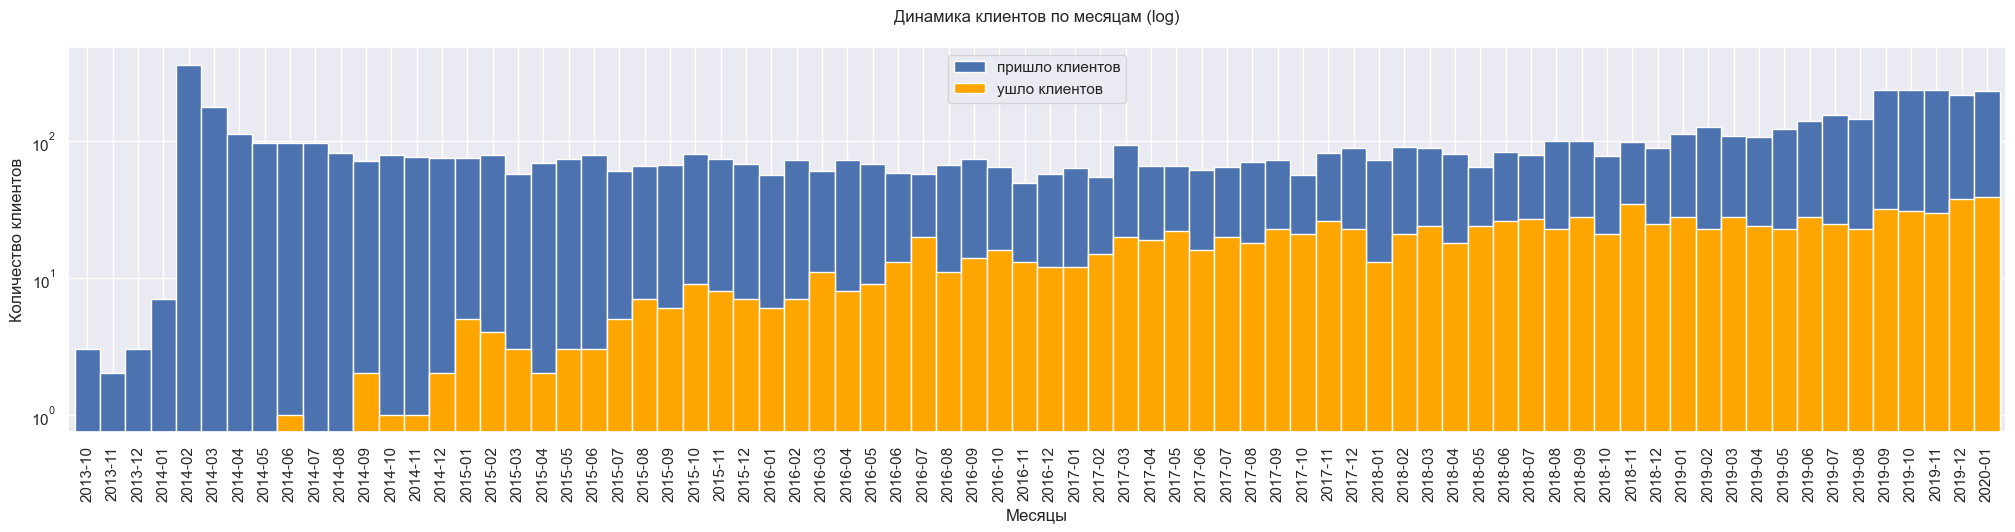

In [13]:
df_begin_date = df.groupby('begin_date')[['customer_id']].count()
df_end_date = df.groupby('end_date')[['customer_id']].count().drop('No')
df_end_date.index = df_end_date.index.astype('datetime64[ns]')

df_to_plot = pd.concat([df_begin_date.rename(columns={'customer_id': 'пришло клиентов'})[:-1], 
                        df_end_date.rename(columns={'customer_id': 'ушло клиентов'})], axis=1).fillna(0)

ax = df_to_plot['пришло клиентов'].plot(kind='bar', figsize=(25, 5),  width=1)
df_to_plot['ушло клиентов'].plot(kind='bar', width=1, color='orange')
plt.yscale('log')
ax.set_xticklabels(df_to_plot.index.strftime("%Y-%m"))
plt.xlabel('Месяцы')
plt.ylabel('Количество клиентов')
plt.title('Динамика клиентов по месяцам (log)\n')
plt.legend()
plt.show()

Видим динамику по месяцам - в среднем приходило клиентов одинаковое количество, а количество уходящих увеличивалось.

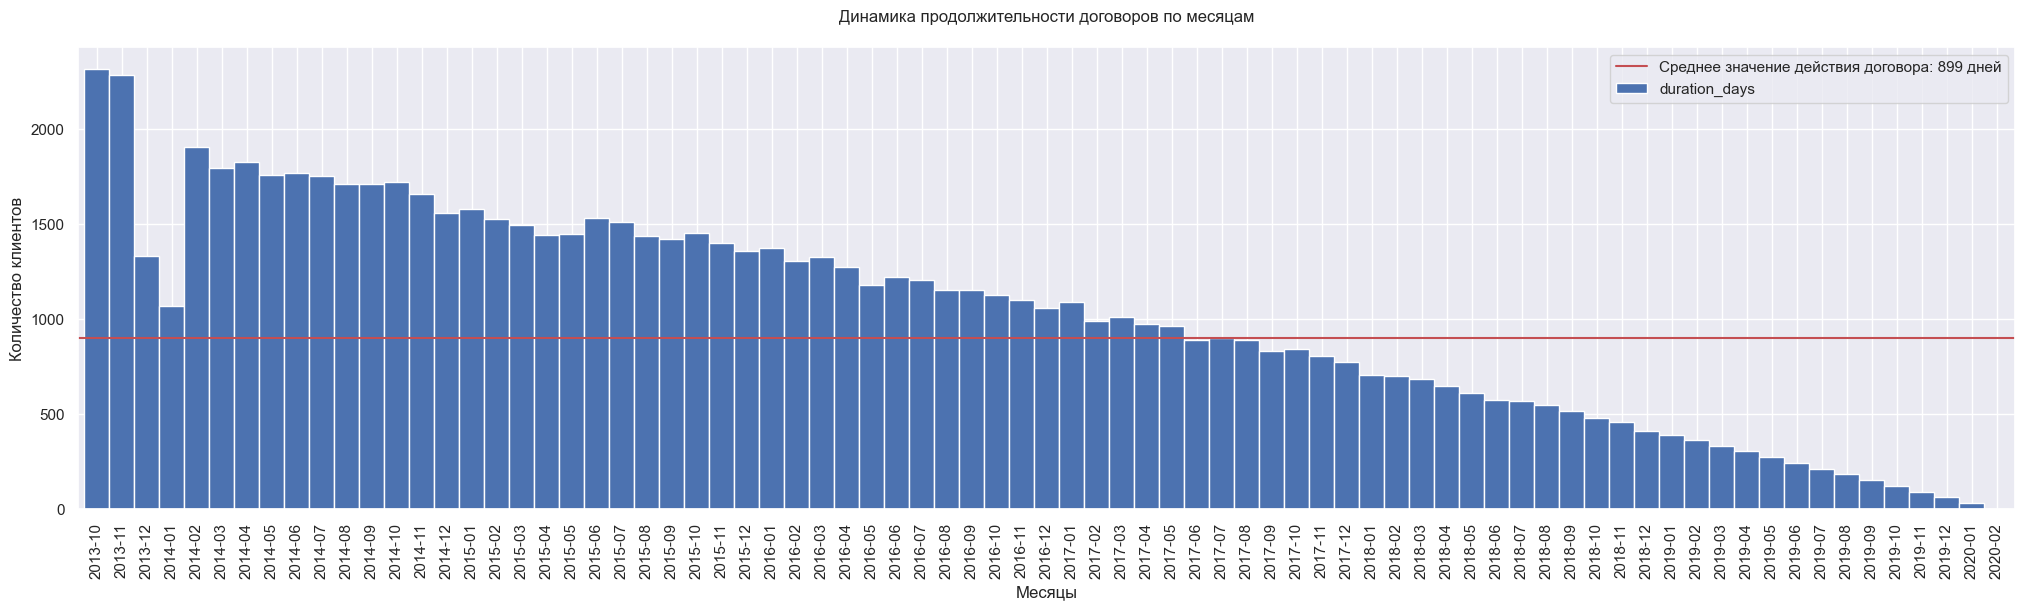

In [14]:
df_to_plot = df.groupby('begin_date')[['duration_days']].mean()
df_to_plot.plot(kind='bar', figsize=(25,6),  width=1).set_xticklabels(df_to_plot.index.strftime("%Y-%m"))
plt.axhline(y = df['duration_days'].mean(), color = 'r', linestyle = '-')
plt.legend(labels = [f"Среднее значение действия договора: {round(df['duration_days'].mean())} дней", 'duration_days'])
plt.xlabel('Месяцы')
plt.ylabel('Количество клиентов')
plt.title('Динамика продолжительности договоров по месяцам\n');

duration_days - длительность договора, для закрытых договоров он идентичен длительности договора, а для действующих - только длительность до настоящего момента, без информации относительно того, будет он закрыт или нет.  
Таким образом, этот параметр у нас сильно коррелирует с временным рядом.

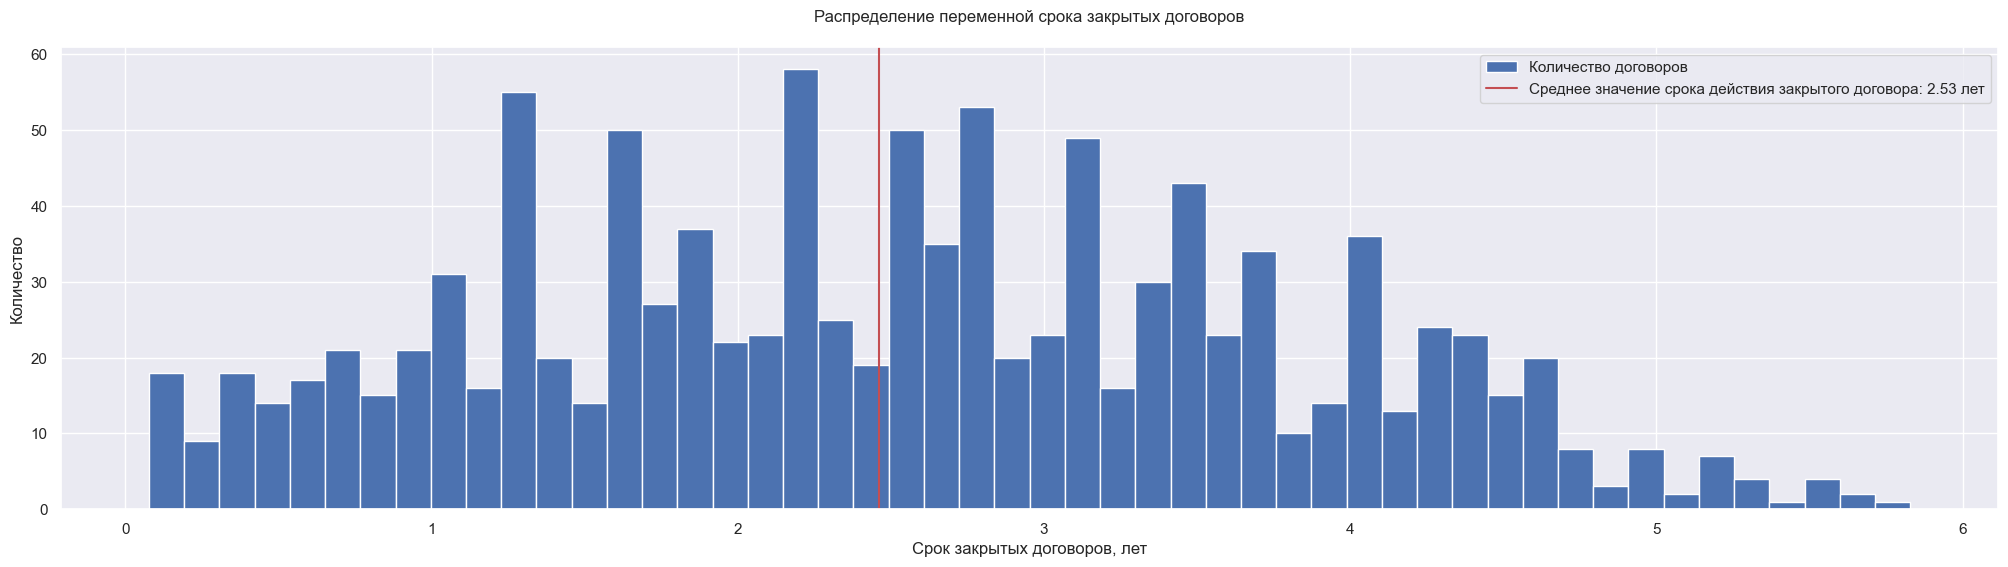

In [15]:
df_to_plot = df[df['end_date']!='No']['duration_days']/365.25
df_to_plot.plot(kind='hist', figsize=(25,6),  bins=50)
plt.xlabel('Срок закрытых договоров, лет')
plt.ylabel('Количество')
plt.title('Распределение переменной срока закрытых договоров\n');
plt.axvline(x = df['duration_days'].mean()/365.25, color = 'r', linestyle = '-')
plt.legend(labels = ['Количество договоров', f"Среднее значение срока действия закрытого договора: {round(df_to_plot.mean(), 2)} лет"]);

In [16]:
df_to_plot.to_frame().describe()

,duration_days
count,1101.000000
mean,2.532139
std,1.256047
min,0.076660
25%,1.579740
50%,2.505133
75%,3.419576
max,5.828884


Мы получили распределение целевой переменной, по которому уже можно статистически прогнозировать отток клиентов, если принять гипотезу, что выборка, состоящая из закрытых договоров, распределена так же, как и весь датасет.

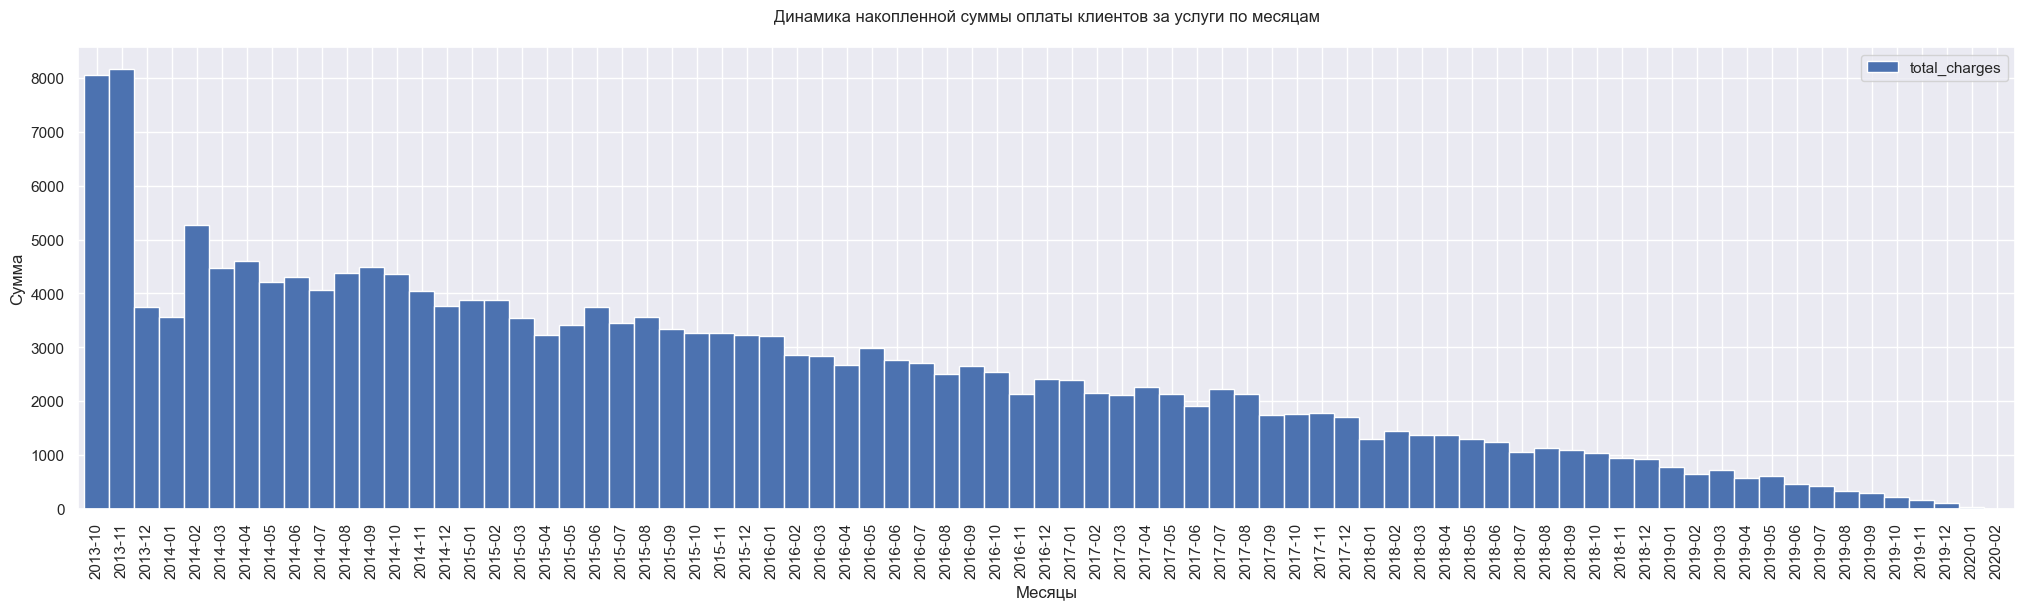

In [17]:
df_to_plot = df.groupby('begin_date')[['total_charges']].mean()
df_to_plot.plot(kind='bar', figsize=(25,6),  width=1).set_xticklabels(df_to_plot.index.strftime("%Y-%m"))
plt.xlabel('Месяцы')
plt.ylabel('Сумма')
plt.title('Динамика накопленной суммы оплаты клиентов за услуги по месяцам\n');

Показатель total_charges - также коррелирует с временным рядом, его средние значения, отнесенные к временным интервалам, того же порядка, что и ежемесячные значения платежей.

In [18]:
df['monthly_charges'].mean(), df['total_charges'].mean()/((df['duration_months']).mean())

(64.76169246059918, 71.71673975622906)

Пропущенные значения - рукотворные, это клиенты, которые не пользуются либо телефонией, либо интернетом.  
Эти пропущенные значения будут учтены при кодировании.

In [19]:
df.fillna('missing', inplace=True)

Удалим ненужные и вспомогательные переменные.

In [20]:
df.drop(['customer_id', 'begin_date', 'end_date', 'duration_end'], axis=1, inplace=True)

In [21]:
display_statistics(df).iloc[:, :6]

,type,count,NaNs,zero_values,unique_values,freq_values
gender,object,7043,0,0,2,"{'Male': 3555, 'Female': 3488}"
senior_citizen,object,7043,0,0,2,"{'No': 5901, 'Yes': 1142}"
partner,object,7043,0,0,2,"{'No': 3641, 'Yes': 3402}"
dependents,object,7043,0,0,2,"{'No': 4933, 'Yes': 2110}"
type,object,7043,0,0,3,"{'Month-to-month': 3875, 'Two year': 1695, 'On..."
paperless_billing,object,7043,0,0,2,"{'Yes': 4171, 'No': 2872}"
payment_method,object,7043,0,0,4,"{'Electronic check': 2365, 'Mailed check': 161..."
monthly_charges,float64,7043,0,0,1585,"{20.05: 61, 19.85: 45, 19.95: 44}"
total_charges,float64,7043,0,11,6658,"{0.0: 11, 20.45: 6, 101.0: 5}"
internet_service,object,7043,0,0,3,"{'Fiber optic': 3096, 'DSL': 2421, 'missing': ..."


Проведем исследование признаков, зависящих от времени.  
Разделим данные на тренировочный и тестовый наборы с учетом дисбаланса (1101 : 5942 ~ 0.15 : 0.85) классов в таргете.

In [22]:
X_train, X_test, y_train, y_test = train_test_split(df.drop('broken', axis=1), df['broken'], test_size=0.25, stratify=df['broken'], random_state=RANDOM_STATE)
X_train.shape, y_train.value_counts(normalize=True)[1], X_test.shape, y_test.value_counts(normalize=True)[1]

((5282, 19), 0.1563801590306702, (1761, 19), 0.15616127200454288)

Для быстрой оценки используем тренировочную выборку, CatBoostClassifier с настройками по умолчанию и без кодирования категориальных переменных.

In [23]:
def get_auc_df(X, y, test_size=0.25):
    cat_features = list(X.select_dtypes(include='object').columns)
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=test_size, random_state=RANDOM_STATE, stratify=y)
    catboost = CatBoostClassifier(verbose=0, cat_features=cat_features, random_state=RANDOM_STATE)
    catboost.fit(Pool(data=X_train, label=y_train, cat_features=cat_features))
    metrics = catboost.eval_metrics(Pool(data=X_val, label=y_val, cat_features=cat_features), metrics=['AUC'])
    return f'AUC: {list(metrics.values())[0][-1]:.4f}'

In [24]:
%%time
col_list = ['total_charges', 'duration_days', 'duration_months']

print('Все переменные:', get_auc_df(X_train, y_train))
for i in range(3):
    print(f'Только {col_list[i]}: {get_auc_df(X_train.drop([x for x in col_list if x != col_list[i]], axis=1), y_train)}')

Все переменные: AUC: 0.8556
Только total_charges: AUC: 0.8103
Только duration_days: AUC: 0.8609
Только duration_months: AUC: 0.8297
CPU times: total: 22.5 s
Wall time: 2min 41s


Как видим, есть смысл оставить переменную duration_days, остальные понижают метрику.

In [25]:
df.drop(['total_charges', 'duration_months'], axis=1, inplace=True)
X_train.drop(['total_charges', 'duration_months'], axis=1, inplace=True)
X_test.drop(['total_charges', 'duration_months'], axis=1, inplace=True)

С переменными определились, визуализируем основные распределения.

In [26]:
target = ['broken']
numeric_features = ['monthly_charges', 'duration_days']
categorical_features = sorted([x for x in df.columns if x not in numeric_features + target])

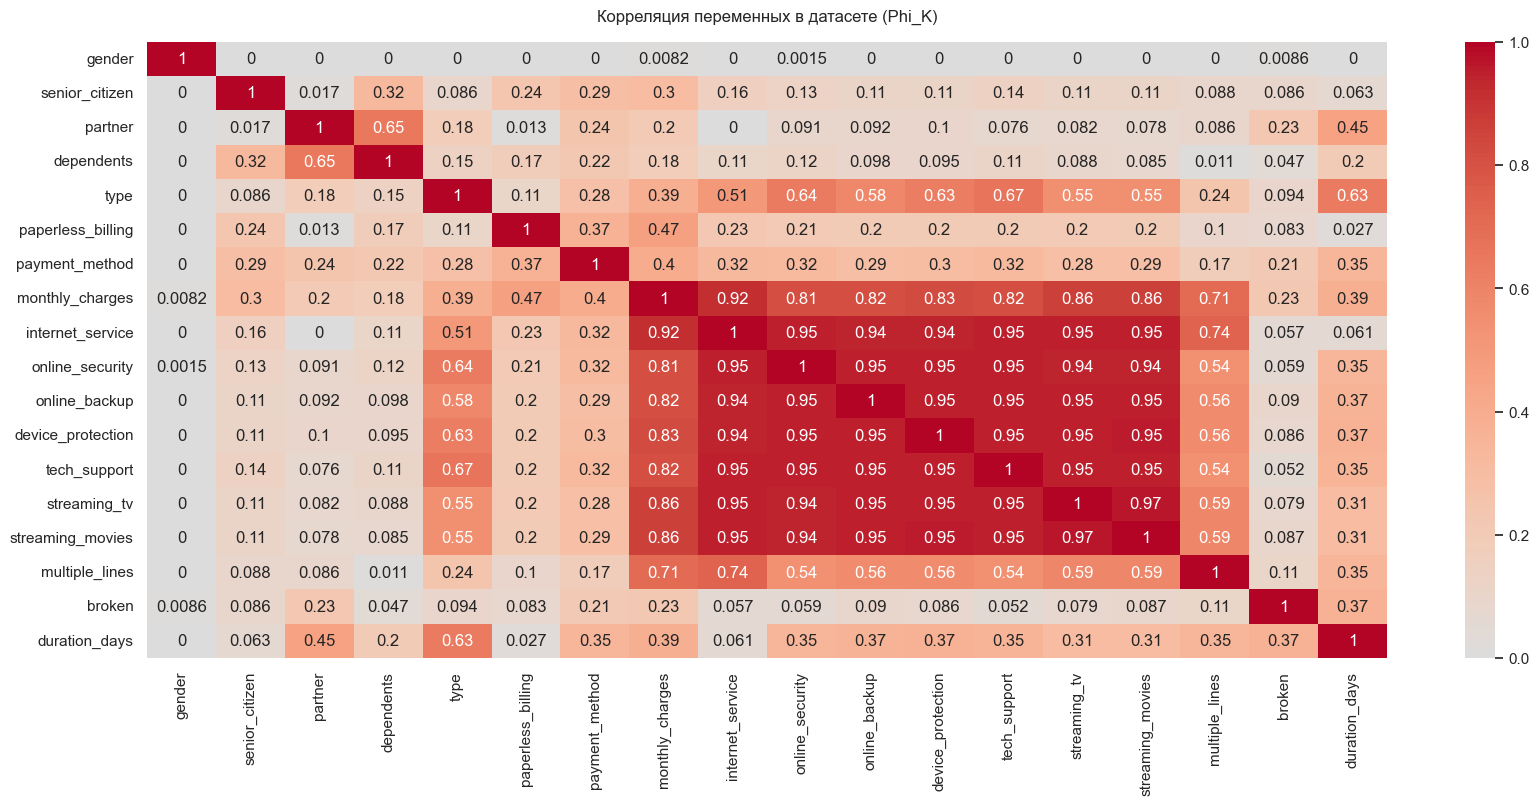

In [27]:
fig, ax = plt.subplots(figsize=(20, 8))
(
    sns.heatmap(df.phik_matrix(interval_cols=numeric_features), cmap='coolwarm', center=0, annot=True)
    .set_title('Корреляция переменных в датасете (Phi_K)', y=1.02)
);

Сильная зависимость признаков, характеризующих интернет-услуги и слабая зависимость от них целевой переменной.  

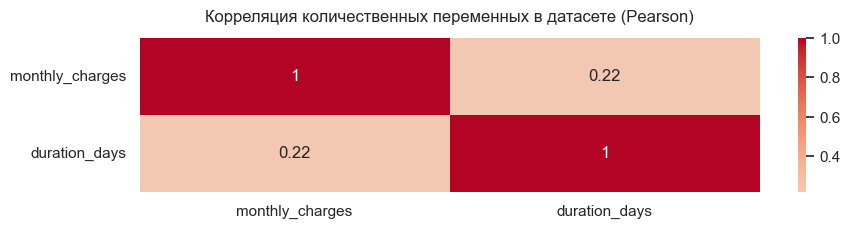

In [28]:
plt.subplots(figsize=(10, 2))
(
    sns.heatmap(df[numeric_features].corr(), cmap='coolwarm', center=0, annot=True)
    .set_title('Корреляция количественных переменных в датасете (Pearson)', y=1.05)
);

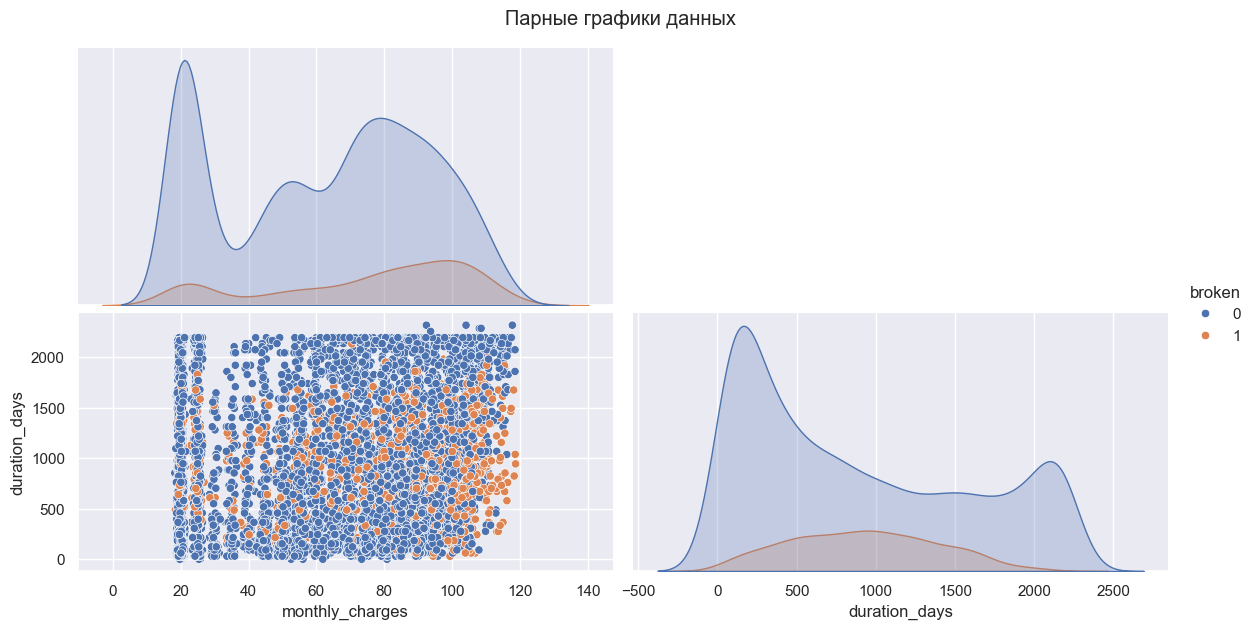

In [29]:
sns.pairplot(df, vars = numeric_features, \
             hue=target[0], corner=True, height=3, aspect=2).fig.suptitle("Парные графики данных", y=1.04);

Договора прекращают клиенты при больших значениях monthly_charges.

In [30]:
display_statistics(df)

,type,count,NaNs,zero_values,unique_values,freq_values,min,mean,max,std,lo_count,hi_count
gender,object,7043,0,0,2,"{'Male': 3555, 'Female': 3488}",---,---,---,---,---,---
senior_citizen,object,7043,0,0,2,"{'No': 5901, 'Yes': 1142}",---,---,---,---,---,---
partner,object,7043,0,0,2,"{'No': 3641, 'Yes': 3402}",---,---,---,---,---,---
dependents,object,7043,0,0,2,"{'No': 4933, 'Yes': 2110}",---,---,---,---,---,---
type,object,7043,0,0,3,"{'Month-to-month': 3875, 'Two year': 1695, 'On...",---,---,---,---,---,---
paperless_billing,object,7043,0,0,2,"{'Yes': 4171, 'No': 2872}",---,---,---,---,---,---
payment_method,object,7043,0,0,4,"{'Electronic check': 2365, 'Mailed check': 161...",---,---,---,---,---,---
monthly_charges,float64,7043,0,0,1585,"{20.05: 61, 19.85: 45, 19.95: 44}",18.25,64.761692,118.75,30.090047,0,0
internet_service,object,7043,0,0,3,"{'Fiber optic': 3096, 'DSL': 2421, 'missing': ...",---,---,---,---,---,---
online_security,object,7043,0,0,3,"{'No': 3498, 'Yes': 2019, 'missing': 1526}",---,---,---,---,---,---


In [31]:
plt.rcParams['figure.figsize'] = [20, 5]

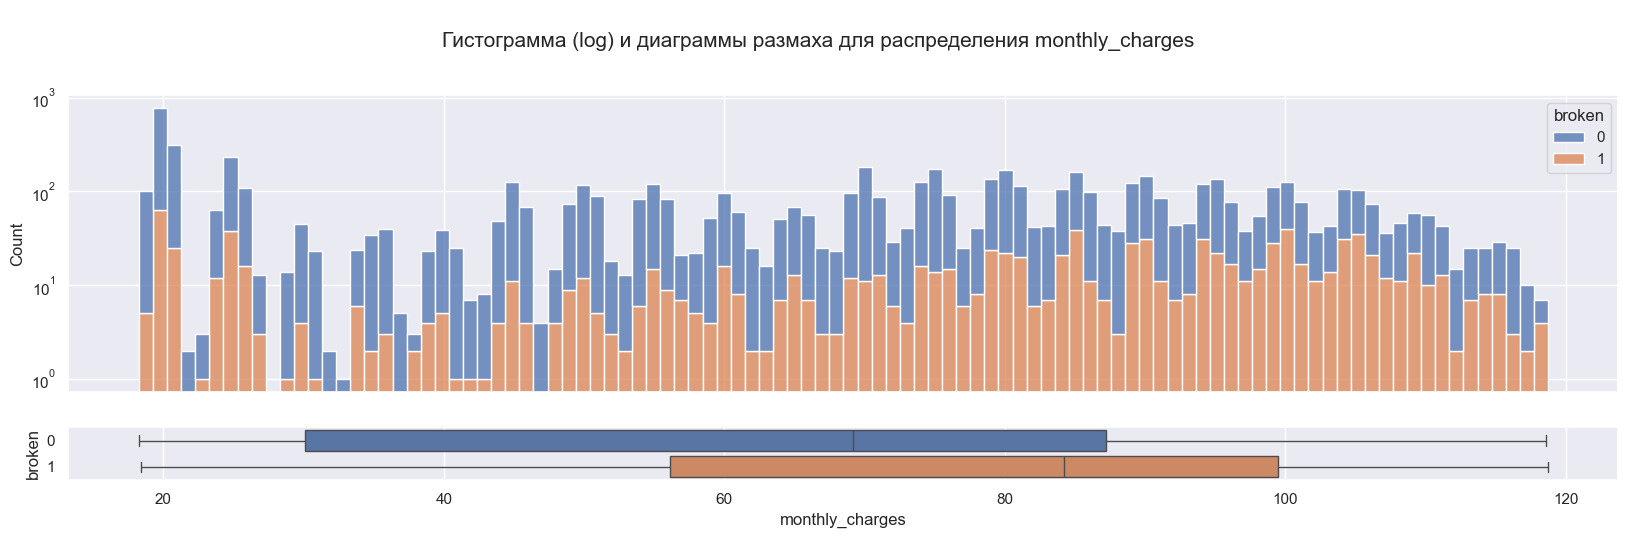

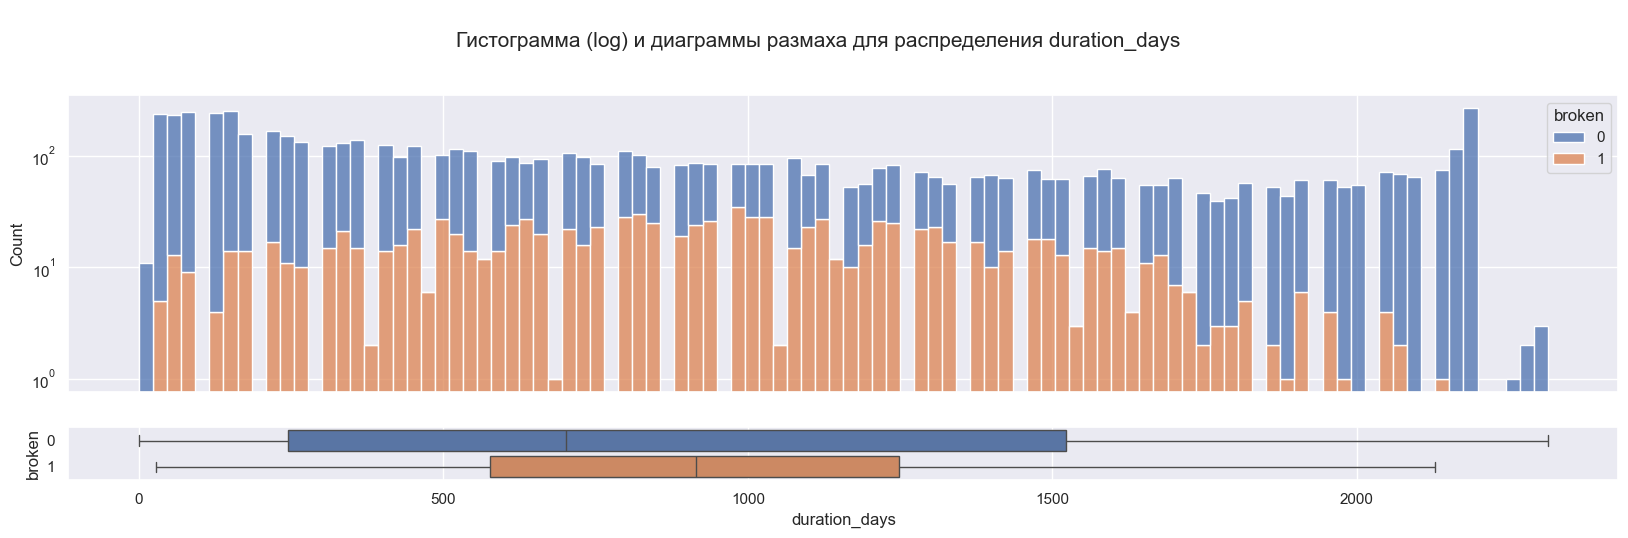

In [32]:
for f in numeric_features:
    fig, (ax_hist, ax_box) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.85, .15)})
    ax_hist.set(yscale="log")
    sns.histplot(data=df, x=f, ax=ax_hist, bins=100, hue=target[0], multiple='stack')
    sns.boxplot(data=df, x=f, y=target[0], orient="h", ax=ax_box, hue=target[0], linewidth=1, legend=None)
    fig.suptitle('\nГистограмма (log) и диаграммы размаха для распределения ' + f, fontsize=15, y=1.05)

Предыдущее наблюдение по поводу monthly_charges также иллюстрирует логарифмическая гистограмма.  
С duration_days посложнее: в среднем срок обслуживания у клиентов, разорвавших договор, немного выше, но при больших значениях duration_days  
клиенты уходят гораздо реже.

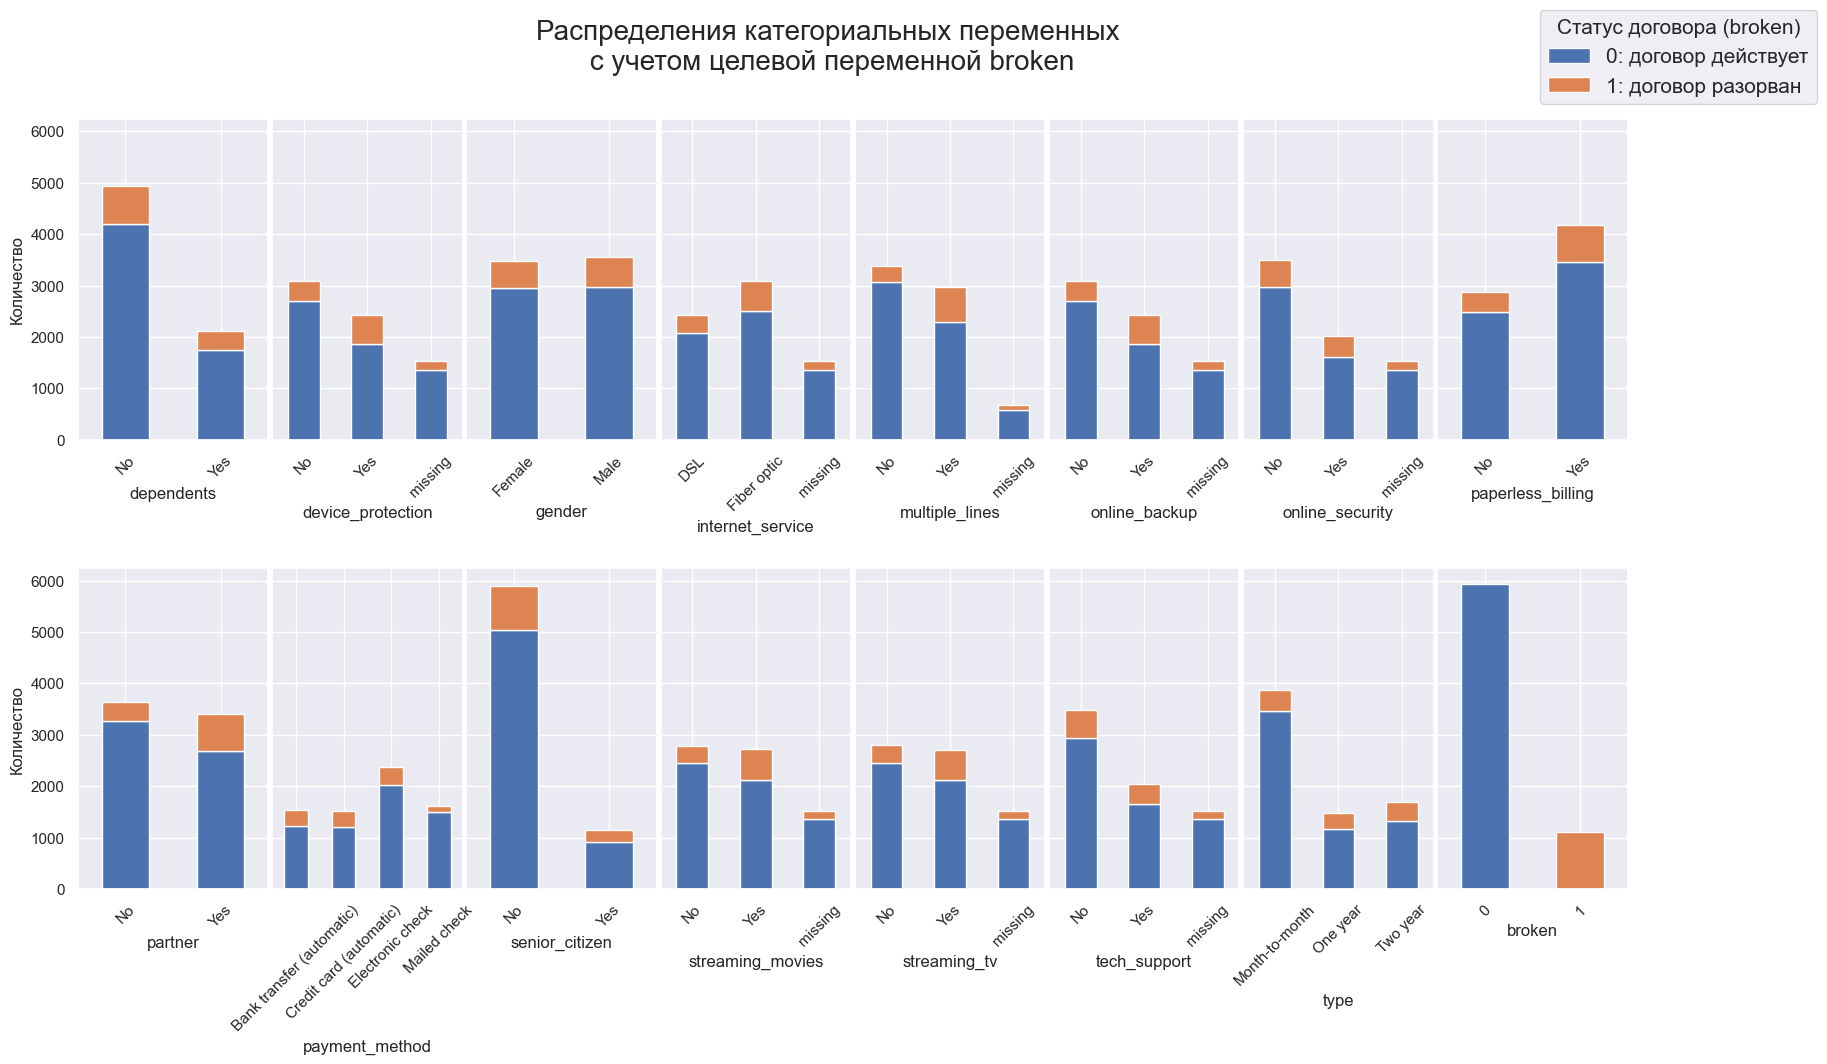

In [33]:
fig, axes = plt.subplots(2, 8, figsize=(20, 10), sharey=True, gridspec_kw = {'wspace':0.02, 'hspace':0.4})

for i in range(len(categorical_features)):
    ax = axes[i // 8, i % 8]
    (df.groupby(target + [categorical_features[i]]).size().reset_index()
        .pivot(columns=target, index=categorical_features[i], values=0)
        .plot(kind='bar', stacked=True, ax=ax))
    ax.get_legend().remove()
    ax.set_ylabel('Количество' if i % 8 == 0 else '')
    ax.tick_params(axis='x', labelrotation=45)

df.groupby(target).size().plot(kind='bar', ax=axes[1,7], color=('C0', 'C1')).tick_params(axis='x', labelrotation=45)

handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, ['0: договор действует', '1: договор разорван'], \
           loc='upper right', fontsize=15, title = 'Статус договора (broken)', title_fontsize=15)
fig.suptitle('Распределения категориальных переменных\n с учетом целевой переменной broken', fontsize=20)
plt.show()

Количество разорванных договоров в различных категориях отличается в переменных dependents, multiple_lines, paperless_billing, partner, senior_sitizen, streaming_tv.  

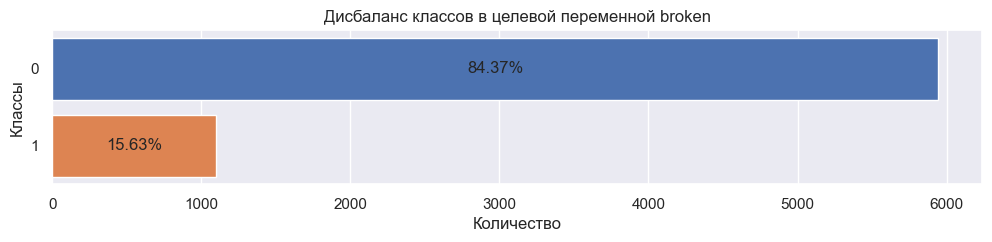

In [34]:
plt.figure(figsize=(12,2))
plot_data = df.groupby(target).size().to_frame().T
labels = [f'{x/sum(plot_data.loc[0,:]):.2%}' for x in plot_data.loc[0,:]]

lab1 = labels[0]

ax = sns.barplot(data=plot_data, orient='h', saturation=1)

# 'bar_label' в matplotlib >= 3.4
ax.bar_label(ax.containers[0], label_type='center', labels=[labels[0]])
ax.bar_label(ax.containers[1], label_type='center', labels=[labels[1]])

plt.title('Дисбаланс классов в целевой переменной ' + target[0]) #, fontsize=12, y=1.05);
plt.ylabel('Классы')
plt.xlabel('Количество');

Дисбаланс большой, в моделях нужно будет это указать.  
Закодируем и нормализуем все переменные, пока оставим наборы в формате pandas.

In [35]:
ord_encoder = make_column_transformer(
    (OrdinalEncoder(), categorical_features),
    (StandardScaler(), numeric_features)
)
X_train_enc = ord_encoder.fit_transform(X_train)
X_test_enc = ord_encoder.transform(X_test)

X_train_df = pd.DataFrame(X_train_enc, columns=categorical_features+numeric_features)
y_train_df = y_train
X_test_df = pd.DataFrame(X_test_enc, columns=categorical_features+numeric_features)
y_test_df = y_test

Посмотрим на корреляции.  
Используем расчет хи-квадрат, Phik, SHAP, а также значения классификатора.

In [36]:
%%time
res = pd.DataFrame(columns=['chi2', 'p-value'])

for x in categorical_features + numeric_features:
    res.loc[x] = [chi2_contingency(pd.crosstab(df[x], df[target[0]],  margins = False))[0],
         chi2_contingency(pd.crosstab(df[x], df[target[0]],  margins = False))[1]]

feature_importance_phik = df.phik_matrix(interval_cols=numeric_features)[target].rename(columns={target[0]: 'phik'})
    
X_train_shap, X_test_shap, y_train_shap, y_test_shap = train_test_split(X_train_df, y_train, test_size=0.25, random_state=RANDOM_STATE, stratify=y_train)
model = CatBoostClassifier(random_state=RANDOM_STATE, verbose=0)
model.fit(X_train_shap, y_train_shap)
explainer = shap.Explainer(model, X_train_shap, seed=RANDOM_STATE)
shap_values = explainer.shap_values(X_test_shap)

res = res.join(feature_importance_phik)
res = res.join(pd.DataFrame(model.feature_importances_, index=X_train_shap.columns).rename(columns={0: 'feat_importance'}))
res = res.join(pd.DataFrame((zip(X_test_shap.columns[np.argsort(np.abs(shap_values).mean(0))][::-1], 
                                 -np.sort(-np.abs(shap_values).mean(0)))), columns=["feature", "shap"]).set_index('feature'))

 98%|===================| 1301/1321 [00:36<00:00]        

CPU times: total: 10.3 s
Wall time: 38.7 s


In [37]:
print('\nТаблица корреляций целевой переменной с независимыми переменными')
res.sort_values(by='shap', ascending=False).style.background_gradient()


Таблица корреляций целевой переменной с независимыми переменными


,chi2,p-value,phik,feat_importance,shap
duration_days,4809.125323,0.000000,0.374569,33.967916,0.916341
type,172.755818,0.000000,0.094015,13.524452,0.755385
monthly_charges,1839.297494,0.000008,0.226280,9.768818,0.346911
partner,150.244240,0.000000,0.226688,3.887007,0.310023
payment_method,146.204112,0.000000,0.214832,5.922401,0.289752
multiple_lines,215.119022,0.000000,0.105101,4.950654,0.278944
online_backup,157.530208,0.000000,0.089704,3.199621,0.150202
tech_support,53.501134,0.000000,0.051537,3.464453,0.140964
paperless_billing,20.897119,0.000005,0.083398,2.815379,0.129470
device_protection,143.716785,0.000000,0.085608,3.453426,0.098272


Статистическая значимость корреляции есть у всех переменных, кроме gender. Все показатели подчеркивают сильную зависимость от duration_days и   
более-менее похожие слабые зависимости от остальных переменных.

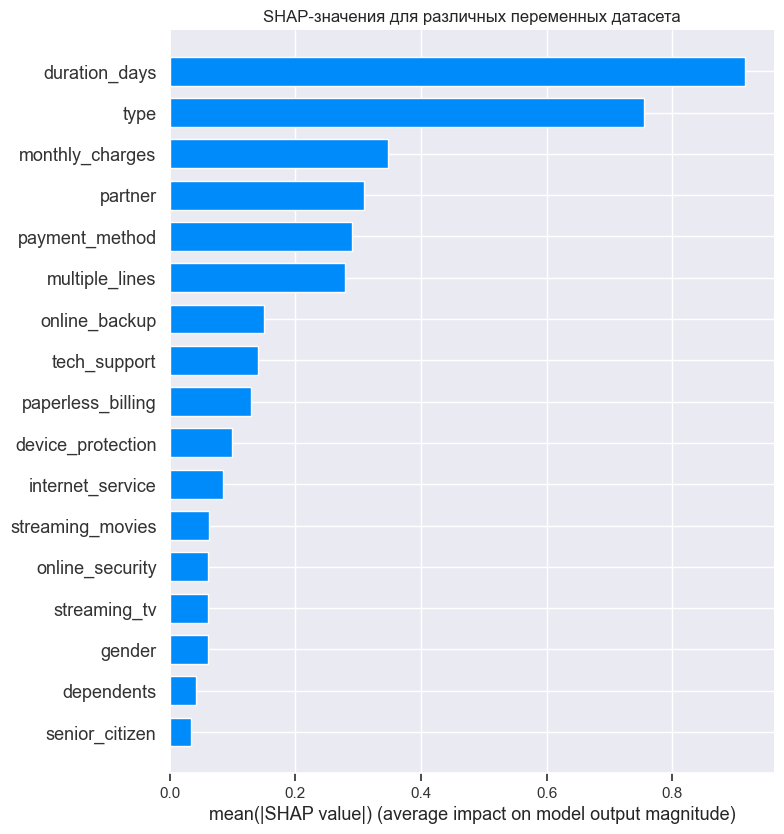

In [38]:
shap.summary_plot(shap_values, X_test_shap, plot_type="bar", show=False)
plt.title("SHAP-значения для различных переменных датасета");

Проведем еще один эксперимент - будем удалять все переменные, начиная от менее зависимых, и заканчивая единственной duration_days.

In [39]:
list_shap = list(res.shap.sort_values().index)
print(list_shap)

['senior_citizen', 'dependents', 'gender', 'streaming_tv', 'online_security', 'streaming_movies', 'internet_service', 'device_protection', 'paperless_billing', 'tech_support', 'online_backup', 'multiple_lines', 'payment_method', 'partner', 'monthly_charges', 'type', 'duration_days']


In [40]:
%%time
for n in range(1, len(list_shap)):
    print('without:', list_shap[:n], get_auc_df(X_train_df.drop(list_shap[:n], axis=1), y_train_df))

without: ['senior_citizen'] AUC: 0.8717
without: ['senior_citizen', 'dependents'] AUC: 0.8724
without: ['senior_citizen', 'dependents', 'gender'] AUC: 0.8726
without: ['senior_citizen', 'dependents', 'gender', 'streaming_tv'] AUC: 0.8744
without: ['senior_citizen', 'dependents', 'gender', 'streaming_tv', 'online_security'] AUC: 0.8709
without: ['senior_citizen', 'dependents', 'gender', 'streaming_tv', 'online_security', 'streaming_movies'] AUC: 0.8732
without: ['senior_citizen', 'dependents', 'gender', 'streaming_tv', 'online_security', 'streaming_movies', 'internet_service'] AUC: 0.8731
without: ['senior_citizen', 'dependents', 'gender', 'streaming_tv', 'online_security', 'streaming_movies', 'internet_service', 'device_protection'] AUC: 0.8790
without: ['senior_citizen', 'dependents', 'gender', 'streaming_tv', 'online_security', 'streaming_movies', 'internet_service', 'device_protection', 'paperless_billing'] AUC: 0.8780
without: ['senior_citizen', 'dependents', 'gender', 'streaming_t

Нельзя сказать, что метрика улучшается, но при удалении признаков нет и ухудшения (можно предположить, что существенно ничего не меняется).  

**Вывод по шагу 2**
  - Данные объединены в один датафрейм по ключу, идентифицирующего клиента
  - Были выбраны и удалены несущественные и вспомогательные признаки
  - Показана динамика потоков клиента по месяцам
  - Для анализа были выбраны все категориальные признаки, два числовых и два признака даты
  - Отмечено, что признаки даты являются определяющими
  - Была проведена визуализация распределений признаков
  - Проведен анализ корреляции признаков
  - Для обучения модели были выбраны один параметр, зависящий от даты, один числовой и оставлены все категориальные

## Обучение моделей машинного обучения

Сначала отберем модели из общего списка, включая константную модель.

In [41]:
def print_metrics(df_res, name='', print_header=False):
    text=''
    if print_header:
        for t in df_res.columns:
            text += f'{t: ^11}'
        print(text)
        return
    text = ''
    for col in df_res.columns:
        if isinstance(df_res.loc[name][col], float):
            text += f' {round(df_res.loc[name][col],4): ^10}'
        else:
            text += f' {str(df_res.loc[name][col])[:45]}'
    print(text)

In [42]:
models = [
    ('DummyClassifier', DummyClassifier(random_state=RANDOM_STATE)),
    ('GaussianNB', GaussianNB()),
    ('LogisticRegression', LogisticRegression(random_state=RANDOM_STATE)),
    ('DecisionTreeClassifier', DecisionTreeClassifier(random_state=RANDOM_STATE)),
    ('RandomForestClassifier', RandomForestClassifier(random_state=RANDOM_STATE)),
    ('RidgeClassifier', RidgeClassifier(random_state=RANDOM_STATE)),
    ('LinearSVC', LinearSVC(random_state=RANDOM_STATE, max_iter=2000)),
    ('KNeighborsClassifier', KNeighborsClassifier()),
    ('AdaBoostClassifier', AdaBoostClassifier(random_state=RANDOM_STATE, algorithm='SAMME')),
    ('LGBMClassifier', LGBMClassifier(random_state=RANDOM_STATE, verbosity=0)), 
    ('XGBClassifier', XGBClassifier(random_state=RANDOM_STATE, verbosity=0, use_label_encoder=False)), 
    ('CatBoostClassifier', CatBoostClassifier(random_state=RANDOM_STATE, verbose=0)),
    ('SGDClassifier', SGDClassifier(random_state=RANDOM_STATE)),
    ('GradientBoostingClassifier', GradientBoostingClassifier(random_state=RANDOM_STATE)),
    ('HistGradientBoostingClassifier', HistGradientBoostingClassifier(random_state=RANDOM_STATE,
                                                                     categorical_features = list(range(15)))),
    ('MLPClassifier', MLPClassifier(hidden_layer_sizes=(32,16), random_state=RANDOM_STATE, max_iter=1000))
]

In [43]:
%%time

X_train, X_val, y_train, y_val = train_test_split(X_train_df, y_train_df, test_size=0.25, random_state=RANDOM_STATE, stratify=y_train_df)

df_res = pd.DataFrame(columns=['recall', 'precision', 'auc', 'accuracy', 'f1_score', 'time', 'model'])
print_metrics(df_res, print_header=True)

for (name, model) in models: 
    start = time.time()
    model.fit(X_train, y_train) 
    model.score(X_val, y_val)

    y_pred = model.predict(X_val)
    rs = recall_score(y_val, y_pred)
    ps = precision_score(y_val, y_pred, zero_division= 0)
    ms = model.score(X_val, y_val)
    f1 = f1_score(y_val, y_pred)
    
    try:
        y_proba = model.predict_proba(X_val)
    except:
        clf = CalibratedClassifierCV(model) 
        clf.fit(X_train, y_train)
        y_proba = clf.predict_proba(X_val)

    y_proba_one = y_proba[:, 1]
    ras = roc_auc_score(y_val, y_proba_one)
    
    df_res.loc[name] = [rs, ps, ras, ms, f1, time.time()-start, str(model)]
    print_metrics(df_res, name)
df_res.sort_values(by='auc', ascending=False)

  recall    precision     auc     accuracy   f1_score     time       model   
    0.0        0.0        0.5       0.8433      0.0       0.004    DummyClassifier(random_state=160224)
   0.401       0.5       0.7384     0.8433     0.445      0.0069   GaussianNB()
   0.1787     0.7551     0.7564     0.8622     0.2891     0.0187   LogisticRegression(random_state=160224)
   0.4155     0.3583     0.6386     0.7918     0.3848     0.0167   DecisionTreeClassifier(random_state=160224)
   0.2754     0.6706     0.8088     0.8653     0.3904     0.2952   RandomForestClassifier(random_state=160224)
   0.0725      1.0       0.7565     0.8547     0.1351     0.033    RidgeClassifier(random_state=160224)
   0.1014     0.8077     0.7562     0.8554     0.1803     0.7279   LinearSVC(max_iter=2000, random_state=160224)
   0.2705     0.5138     0.7121     0.8456     0.3544     0.3221   KNeighborsClassifier()
   0.2609     0.7013     0.8359     0.8668     0.3803     0.1184   AdaBoostClassifier(algorithm='SAMME

,recall,precision,auc,accuracy,f1_score,time,model
XGBClassifier,0.473430,0.796748,0.872978,0.898562,0.593939,0.097580,"XGBClassifier(base_score=None, booster=None, c..."
CatBoostClassifier,0.386473,0.851064,0.868485,0.893263,0.531561,2.063878,<catboost.core.CatBoostClassifier object at 0x...
LGBMClassifier,0.429952,0.780702,0.849725,0.891749,0.554517,0.155353,"LGBMClassifier(random_state=160224, verbosity=0)"
GradientBoostingClassifier,0.309179,0.800000,0.849025,0.879637,0.445993,0.298742,GradientBoostingClassifier(random_state=160224)
HistGradientBoostingClassifier,0.376812,0.735849,0.848620,0.881151,0.498403,1.000151,HistGradientBoostingClassifier(categorical_fea...
AdaBoostClassifier,0.260870,0.701299,0.835929,0.866768,0.380282,0.118365,"AdaBoostClassifier(algorithm='SAMME', random_s..."
RandomForestClassifier,0.275362,0.670588,0.808808,0.865254,0.390411,0.295201,RandomForestClassifier(random_state=160224)
RidgeClassifier,0.072464,1.000000,0.756481,0.854656,0.135135,0.033017,RidgeClassifier(random_state=160224)
LogisticRegression,0.178744,0.755102,0.756416,0.862226,0.289062,0.018744,LogisticRegression(random_state=160224)
LinearSVC,0.101449,0.807692,0.756156,0.855413,0.180258,0.727939,"LinearSVC(max_iter=2000, random_state=160224)"


По метрике AUC отбираем первые 5 классификаторов (часть моделей показали метрики хуже константной).  
Подбор гиперпараметров был произведен, указаны более-менее оптимальные значения.  
Использовался поиск по сетке с кросс-валидацией по 5 фолдам.

In [44]:
%%time
params = [
    {
    'classifier__n_estimators': [100, 300, 500],
    'classifier__learning_rate': [0.1, 0.3], 
    'classifier__max_depth': [4, 8], 
    'classifier__reg_lambda': [0.1], 
    'classifier': [LGBMClassifier(random_state=RANDOM_STATE, class_weight='balanced', objective='binary')] 
    }, 
    {
    'classifier__n_estimators': [100, 300],
    'classifier__learning_rate': [0.3], 
    'classifier__max_depth': [5, 10],  
    'classifier__reg_lambda': [0.1], 
    'classifier__scale_pos_weight': [4],
    'classifier': [XGBClassifier(random_state=RANDOM_STATE, verbosity=0, use_label_encoder=False)] 
    },
    {
    'classifier__max_iter': [200, 500, 700], 
    'classifier__learning_rate': [0.05, 0.1], 
    'classifier__max_depth': [3],  
    'classifier__l2_regularization': [0.025], 
    'classifier': [HistGradientBoostingClassifier(random_state=RANDOM_STATE, categorical_features = list(range(15)))]
    },
    {
    'classifier__n_estimators': [400, 600, 800], 
    'classifier__learning_rate': [0.1, 0.2], 
    'classifier__max_depth': [2, 4],  
    'classifier__min_samples_split': [8, 10], 
    'classifier': [GradientBoostingClassifier(random_state=RANDOM_STATE)] 
    },
    {
    'classifier__learning_rate': [0.1, 0.2],
    'classifier__iterations': [100, 500, 1000, 1200], 
    'classifier__depth': [3, 6],
    'classifier': [CatBoostClassifier(random_state=RANDOM_STATE, verbose=0)]
    }

]

pipeline = Pipeline([('classifier', LGBMClassifier(random_state=RANDOM_STATE))])

gs = GridSearchCV(pipeline, params, cv=5, n_jobs=-1, scoring='roc_auc', verbose=3).fit(X_train, y_train)
#gs = RandomizedSearchCV(pipeline, params, cv=5, n_jobs=-1, scoring='roc_auc', verbose=3).fit(X_train, y_train)

print(gs.best_params_)
print(gs.best_score_)

Fitting 5 folds for each of 62 candidates, totalling 310 fits
{'classifier': GradientBoostingClassifier(learning_rate=0.2, max_depth=2, min_samples_split=10,
                           n_estimators=800, random_state=160224), 'classifier__learning_rate': 0.2, 'classifier__max_depth': 2, 'classifier__min_samples_split': 10, 'classifier__n_estimators': 800}
0.9088853484705517
CPU times: total: 1.12 s
Wall time: 1min 11s


**Вывод по шагу 3**
  - Был произведен предварительный отбор моделей для общего списка (классификаторы), включая константную модель
  - По показателям метрик было выбрано 5 моделей
  - Для выбранных моделей был проведен поиск по сетке (представлены только результаты этого поиска)
  - По результатам была выбрана лучшая модель GradientBoostingClassifier

## Выбор лучшей модели

Выбрали лучшую модель от sklearn.

In [45]:
gs.best_estimator_[0]

GradientBoostingClassifier(learning_rate=0.2, max_depth=2, min_samples_split=10,
                           n_estimators=800, random_state=160224)

In [46]:
predict_proba = gs.predict_proba(X_test_df)[:, 1]
print('ROC AUC score:', roc_auc_score(y_test_df, predict_proba))

ROC AUC score: 0.9265863208124312


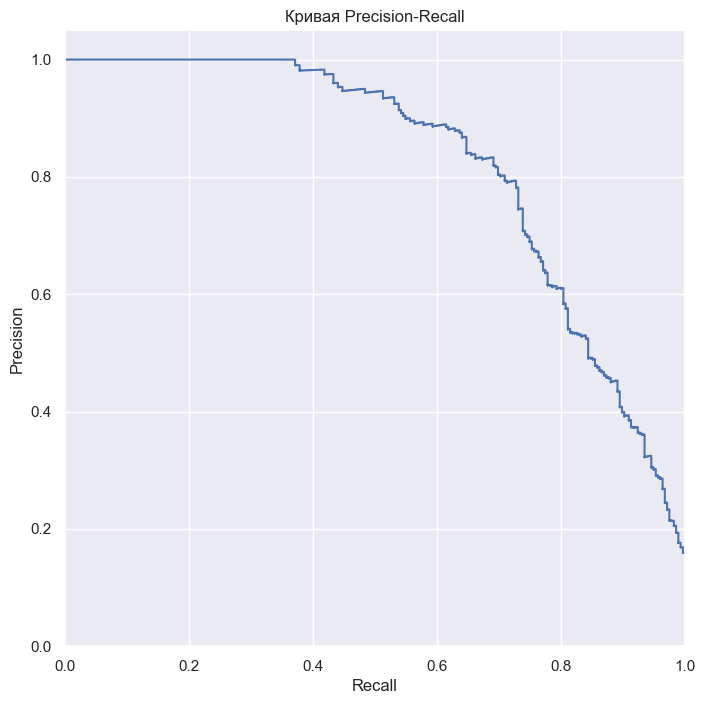

In [47]:
model = gs.best_estimator_[0]
pr_rec_curve(model, X_test_df, y_test_df)

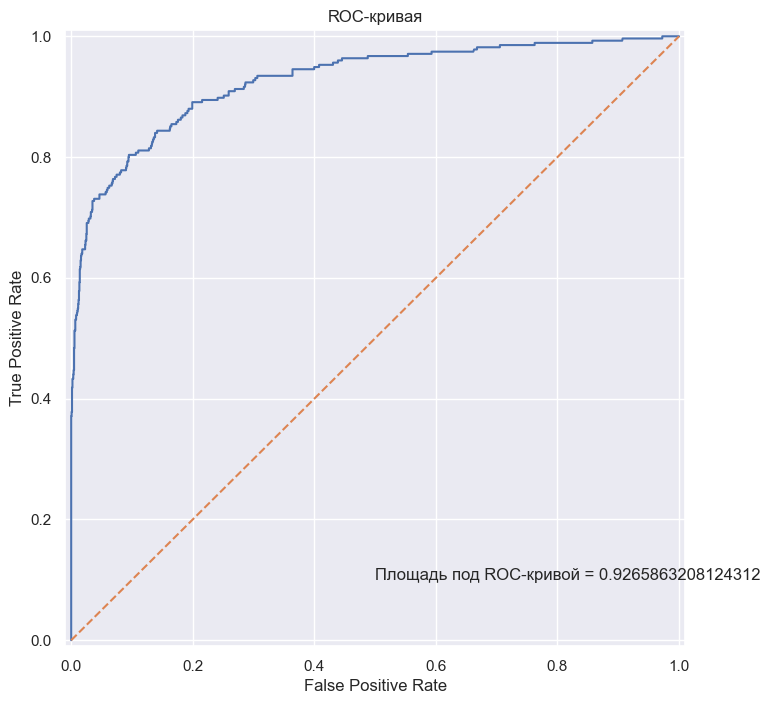

In [48]:
plot_roc_auc(model, X_test_df, y_test_df)

In [49]:
predictions = model.predict(X_test_df)
print_classification_report(y_test_df, predictions)

,precision,recall,f1-score,support
,,,,
0,0.934227,0.984522,0.958716,1486.00000
1,0.882051,0.625455,0.731915,275.00000
accuracy,,,,0.92845
macro avg,0.908139,0.804988,0.845315,1761.00000
weighted avg,0.926079,0.92845,0.923298,1761.00000


Из 100% прогнозов целевой переменной модель указала ~88% правильно (точность), а из общего количества действительных значений ~ 63% (полнота).  

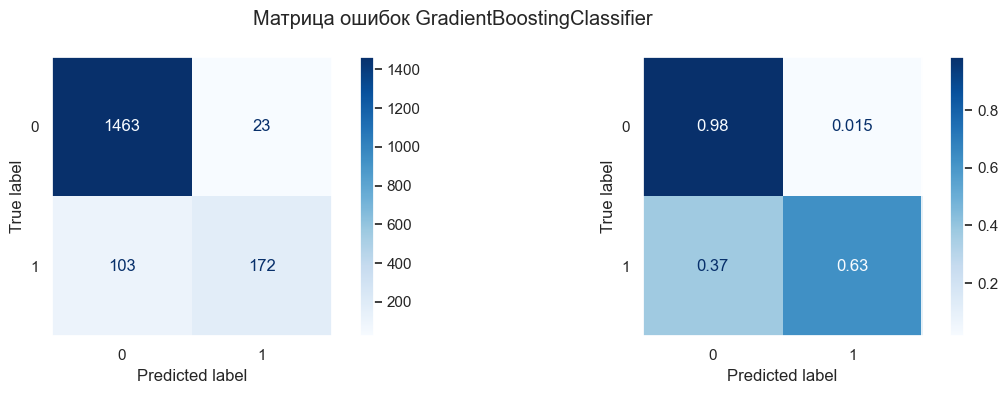

In [50]:
cm = confusion_matrix(y_test_df, predictions, labels=model.classes_)
cm_norm = confusion_matrix(y_test_df, predictions, labels=model.classes_, normalize='true')

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,4))
fig.suptitle('Матрица ошибок ' + type(gs.best_estimator_[0]).__name__)
ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_).plot(ax=ax1, cmap='Blues')
ConfusionMatrixDisplay(confusion_matrix=cm_norm, display_labels=model.classes_).plot(ax=ax2, cmap='Blues')

ax1.grid(False)
ax2.grid(False)
plt.tight_layout()
plt.show();

Из 275 реальных значений целевой переменной модель определила 173, и сделала 23 неправильных предсказания целевого класса.

Выведем параметры важности признаков модели.

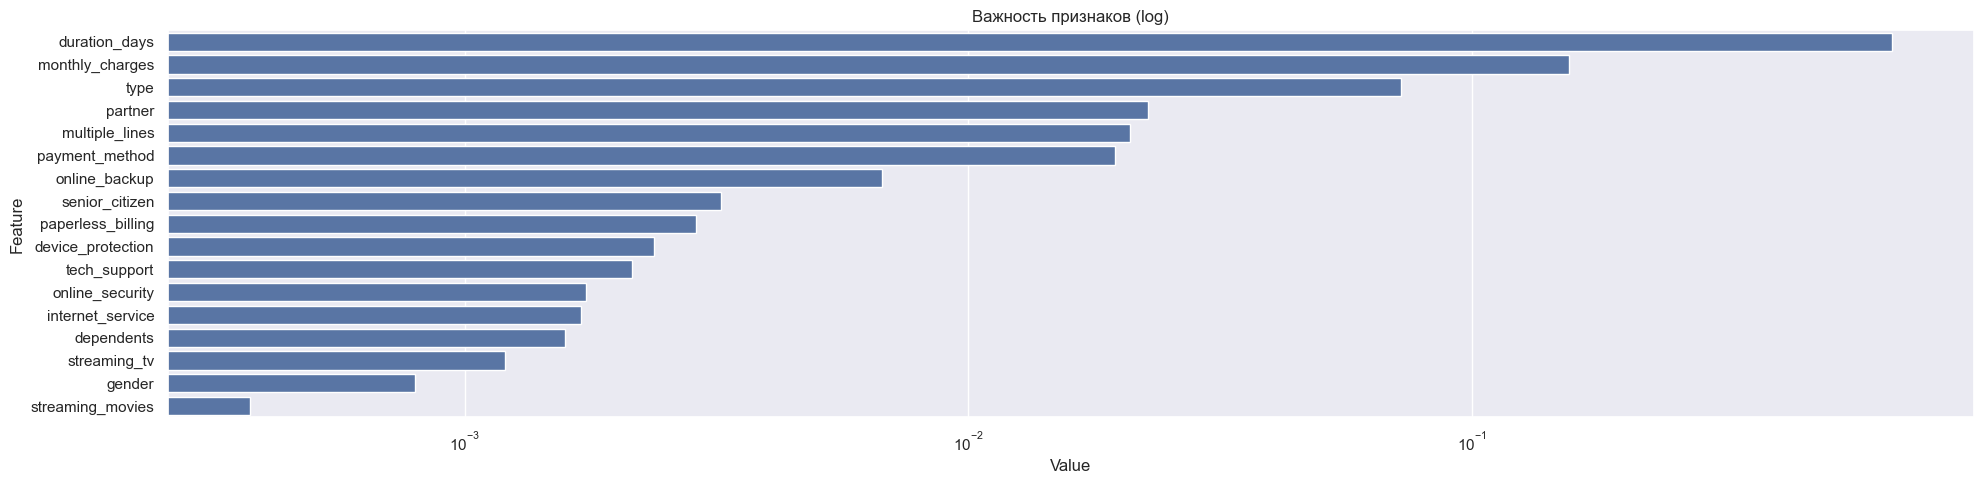

In [51]:
feature_importance = gs.best_estimator_[0].feature_importances_
feature_imp = pd.DataFrame(sorted(zip(feature_importance, X_train.columns)), columns=['Value','Feature'])
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False))
plt.title('Важность признаков (log)')
plt.xscale('log')
plt.tight_layout()
plt.show();

**Вывод по шагу 4**
  - Была произведена оценка качества модели
  - Построены основные визуализации показателей качества
  - Выведены основные метрики модели

## Общий вывод и рекомендации заказчику

**Общие выводы**
  - Заказчиком была поставлена задача прогнозирования оттока клиентов для оператора связи
  - Были успешно получены и загружены 4 датасета, в которых содержатся данные о клиентах, о заключенных договорах на обслуживание, об интернет-услугах и уcлугах телефонии
  - Все датасеты были объединены в один по ключевому полю, идентифицирующему каждого клиента
  - Был произведен анализ признаков (2 числовых, 2 признака даты и 15 категориальных признаков), а также выделена целевая переменная
  - Были построены распределения всех признаков, дан анализ динамики оттока клиентов
  - Отмечен дисбаланс в целевой переменной (~ 85:15)
  - Для обучения модели был выбран один числовой признак (месячная оплата), признак временного интервала (срок действия договора) и все категориальные, характеризующие клтиента и набор предоставляемых услуг
  - Отмечено, что срок действия договора, являясь определяющим признаком, может послужить основой для статистического решения задачи (получено распределение, позволяющее рассчитать вероятности оттока клиентов стандартными статистическими методами)
  - Анализ корреляции показал, что основным признаком является срок действия договора, влияние остальных признаков слабое
  - Был произведено тестирование популярных моделей для классификации, выбрано 5 лучших
  - Из 5 лучших методом поиска по сетке с кросс-валидацией выбрана модель GradientBoostingClassifier
  - Были выведены основные метрики и даны оценки качества модели, основной показатель ROC AUC: ~0.93
  - Одним из дальнейших улучшений модели является проведение мер по борьбе с дисбалансом таргета

**Рекомендации заказчику**
  - Полученая модель позволяет решить поставленную задачу, а именно - оценки действующих клиентов
  - На новых данных модель может показывать плохие результаты, т.к. у определяющего признака (действующих договоров) сильная зависимость от последней даты
  - На основании имеющихся данных возможны приближенные расчеты динамики оттока клиентов традиционными статистическими методами
  - Для поставленной задачи важной метрикой является не точность, а полнота, поэтому можно расширить оценку количества клиентов, склонных к разрыву договора, путем, например, понижения порога классификации
  - Для улучшения модели необходимо больше данных - более точная история каждого клиента, более глубокая детализация его расходов и потребляемых услуг
  - Список важности услуг, влияющих на целевую переменную, может быть использован для выработки приоритетов в их развитии и рекомендаций этих услуг клиентам